In [2]:
#Q1
from os import listdir
from os.path import isfile, join
import numpy as np
import random
import matplotlib.pyplot as plt
import cv2
import matplotlib.image as mpimg


#1)loading images

mypathL='C:\\Users\\Asus\\Desktop\\img2'
mypathR='C:\\Users\\Asus\\Desktop\\img3'
onlyfilesL = [ f for f in listdir(mypathL) if isfile(join(mypathL,f)) ]
onlyfilesR = [ f for f in listdir(mypathR) if isfile(join(mypathR,f)) ]
imgL = np.empty(len(onlyfilesL), dtype=object)
L=np.empty(len(onlyfilesL), dtype=object)
imgR = np.empty(len(onlyfilesR), dtype=object)
R=np.empty(len(onlyfilesR), dtype=object)

for n in range(len(onlyfilesL)):
    L[n] = cv2.imread( join(mypathL,onlyfilesL[n]) )
    #L[n] = cv2.cvtColor(imgL[n], cv2.COLOR_BGR2GRAY)

for n in range(len(onlyfilesR)):
    R[n] = cv2.imread( join(mypathR,onlyfilesR[n]) )
    #R[n] = cv2.cvtColor(imgR[n], cv2.COLOR_BGR2GRAY)    
print(L[0].shape)
print(np.max(L[0][:,:,0]),np.max(L[0][:,:,1]),np.max(L[0][:,:,2]))
#print(L[0].shape)
#for i in range(21):
  #  imgL[i]=imgL[i].reshape((370,1226,3))

(370, 1226, 3)
255 255 255


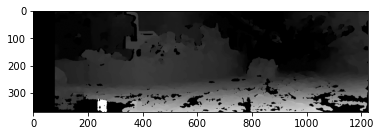

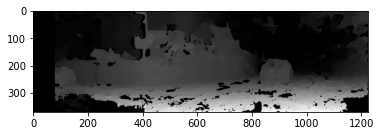

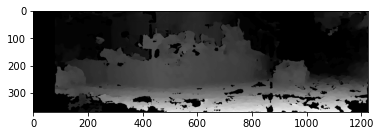

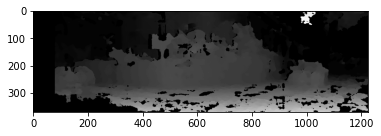

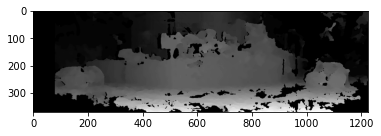

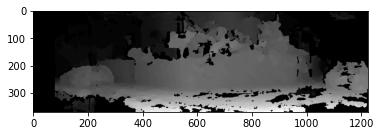

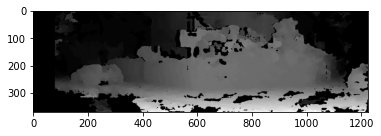

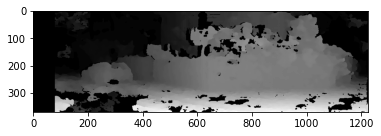

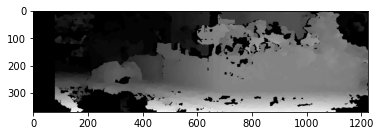

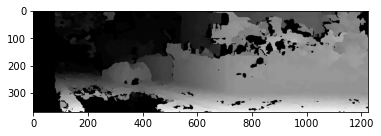

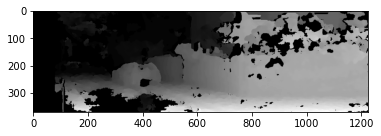

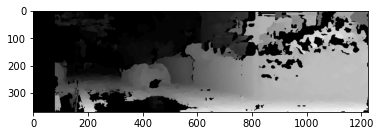

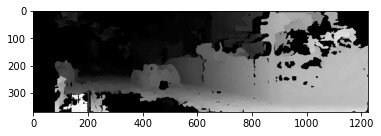

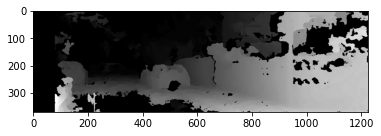

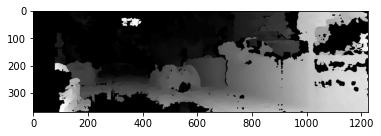

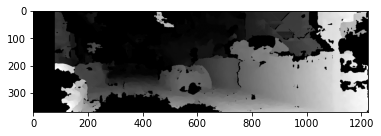

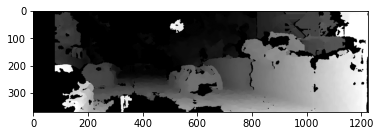

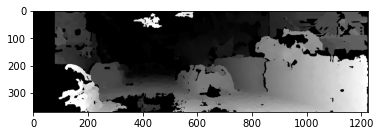

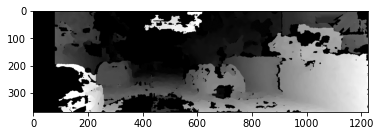

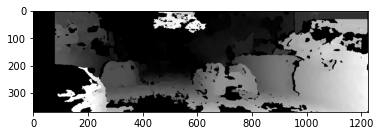

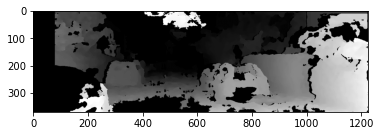

(21, 370, 1226)


In [3]:
disparity= np.empty((21,370,1226))
stereo = cv2.StereoSGBM_create( minDisparity = 16,
 numDisparities = 64,
 blockSize = 13,
 P1 = 600,
 P2 = 2400,
 disp12MaxDiff = -1,
 preFilterCap = 0,
 uniquenessRatio = 0,
 speckleWindowSize = 1000,
 speckleRange = 1
)
for i in range(21):
    disparity[i] = stereo.compute(L[i],R[i]).astype(np.float32) / 16.0
    #print(L[i].shape)
    
    plt.imshow(disparity[i],'gray')
    plt.show()
print(disparity.shape)
disparity=np.absolute(disparity)
disparity = disparity / 64.0

In [5]:
def P_Cloud(disparity,L):
    b=0.53790448812
    K=np.array([[7.070912e+02, 0.000000e+00, 6.018873e+02],
                [0.000000e+00, 7.070912e+02, 1.831104e+02],
                [0.000000e+00, 0.000000e+00, 1.000000e+00]])
    f=7.070912e+02
    X= np.zeros((370,1226))
    Y= np.zeros((370,1226))
    Z= np.zeros((370,1226))
    P_Cl=np.zeros((453620,3))
    C=np.ones((370,1226,3))
    D=np.ones((370,1226,3))
    C=C+D
    for j in range(370):
        for k in range(1226):
            if (disparity[j,k]>0):
                X[j,k] = (k+1)*b/(disparity[j,k])
                Y[j,k] = (j+1)*b/(disparity[j,k])
                Z[j,k] = f*b/disparity[j,k]
                C[j,k,0]= L[j,k,0]/255
                C[j,k,1]= L[j,k,1]/255
                C[j,k,2]= L[j,k,2]/255
    X=np.reshape(X,(453620,1))  
    Y=np.reshape(Y,(453620,1))  
    Z=np.reshape(Z,(453620,1))
    C=np.reshape(C,(453620,3))
    for i in range(453620):
        P_Cl[i,0]=X[i]
        P_Cl[i,1]=Y[i]
        P_Cl[i,2]=Z[i]

    P= np.delete(P_Cl, np.where(P_Cl == [0, 0, 0]), axis=0)  
    C= np.delete(C, np.where(C == [2, 2, 2]), axis=0)  
    #C=C.tolist()
    #print(np.max(L[:,:,0]),np.max(L[:,:,1]),np.max(L[:,:,2]))
    #print(P.shape)
    return(P,C) 


In [6]:
#function to obtain Point cloud for each image
CLOUD=np.ndarray((21),dtype=object)
C_CLOUD=np.ndarray((21),dtype=object)
C=[]
for i in range(21):
    D=disparity[i]
    CLOUD[i],C_CLOUD[i]=P_Cloud(D,L[i])
    C_CL=C_CLOUD[i].tolist()
    C.extend(C_CL)
#print(CLOUD[0],len(C)) 
C=np.asarray(C)
print(C.shape)
#print('0th color',C_CLOUD[0].shape)

(9526020, 3)


In [7]:
#getting no.of points of each image's point cloud and creating a matrix of variable size to store them
a=np.empty((21))
for i in range(21):
    a[i]=len(CLOUD[i])
a=a.astype(int)
Cloud_W=np.ndarray((21),dtype=object)
for i in range(21):
    Cloud_W[i]=np.empty((a[i],3))
#p=np.sum(a)
#print(p)

In [8]:
#Transforming each 3D point cloud in the world coordinate frame

GT = np.loadtxt('poses.txt')
GT = GT.reshape((21,3,4))
X_180=np.array([[1,0,0],[0,-1,0],[0,0,-1]])
for i in range(21):
    k=a[i]
    #print(k)
    #Cloud_W[i]=np.empty((k,3))
    Point=np.empty((a[i],3))
    A = np.append(GT[i],[[0,0,0,1]],axis=0)
    for j in range(k):
                    Point[j]=CLOUD[i][j]
                    P=np.append(Point[j],[1],axis=0)
                    S = np.matmul(A,P)
                    S = np.reshape(S,(4,1))
                    S = S/S[3,0]
                    Cloud_W[i][j,0]=S[0,0]
                    Cloud_W[i][j,1]=S[1,0]
                    Cloud_W[i][j,2]=S[2,0] 
                    Cloud_W[i][j]=np.matmul(Cloud_W[i][j],X_180)
                    CLOUD[i][j]=np.matmul(CLOUD[i][j],X_180)



In [9]:
#Creating an array of all world's point cloud
W0=Cloud_W[0].tolist()
W1=Cloud_W[1].tolist()
W2=Cloud_W[2].tolist()
W3=Cloud_W[3].tolist()
W4=Cloud_W[4].tolist()
W5=Cloud_W[5].tolist()
W6=Cloud_W[6].tolist()
W7=Cloud_W[7].tolist()
W8=Cloud_W[8].tolist()
W9=Cloud_W[9].tolist()
W10=Cloud_W[10].tolist()
W11=Cloud_W[11].tolist()
W12=Cloud_W[12].tolist()
W13=Cloud_W[13].tolist()
W14=Cloud_W[14].tolist()
W15=Cloud_W[15].tolist()
W16=Cloud_W[16].tolist()
W17=Cloud_W[17].tolist()
W18=Cloud_W[18].tolist()
W19=Cloud_W[19].tolist()
W20=Cloud_W[20].tolist()

W0.extend(W1)
W0.extend(W2)
W0.extend(W3)
W0.extend(W4)
W0.extend(W5)
W0.extend(W6)
W0.extend(W7)
W0.extend(W8)
W0.extend(W9)
W0.extend(W10)
W0.extend(W11)
W0.extend(W12)
W0.extend(W13)
W0.extend(W14)
W0.extend(W15)
W0.extend(W16)
W0.extend(W17)
W0.extend(W18)
W0.extend(W19)
W0.extend(W20)

#print(len(W0))
W=np.asarray(W0)
#print(W.shape)

In [11]:
#converting 3D point numpy to open 3D point cloud

import open3d as o3d
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(W)
pcd.colors = o3d.utility.Vector3dVector(C)
o3d.io.write_point_cloud("./output.ply", pcd)
print(pcd)
print(np.asarray(pcd.points))
o3d.visualization.draw_geometries([pcd])
np.savetxt('C:\\Users\\Asus\\Desktop\\Points.txt',W)

geometry::PointCloud with 9526020 points.
[[ -856.77279871   -70.91161058  1422.5010966 ]
 [ -858.86096929   -71.00611717  1421.55351602]
 [ -860.94913987   -71.10062376  1420.60593544]
 ...
 [-1760.70653913 -1025.74226968  2732.76961596]
 [-1762.68229083 -1025.84341835  2733.93300371]
 [-1764.65804253 -1025.94456702  2735.09639145]]


In [182]:
#Checking for single pic in the first camera frame
import open3d as o3d   
A=CLOUD[0]
B=C_CLOUD[0]
print(A.shape)
np.savetxt('C:\\Users\\Asus\\Desktop\\pic.txt',A)
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(A)
pcd.colors = o3d.utility.Vector3dVector(B)
o3d.io.write_point_cloud("./output.ply", pcd)
print(pcd)
print(np.asarray(pcd.points))
o3d.visualization.draw_geometries([pcd])



(453620, 3)
geometry::PointCloud with 453620 points.
[[ 2.29505915e+00 -2.29505915e+00 -1.62281613e+03]
 [ 4.59011830e+00 -2.29505915e+00 -1.62281613e+03]
 [ 6.88517745e+00 -2.29505915e+00 -1.62281613e+03]
 ...
 [ 2.80915240e+03 -8.49171885e+02 -1.62281613e+03]
 [ 2.81144746e+03 -8.49171885e+02 -1.62281613e+03]
 [ 2.81374252e+03 -8.49171885e+02 -1.62281613e+03]]


In [157]:
#Q2 Defining P as a product of K and Rt
K=np.array([[7.070912e+02, 0.000000e+00, 6.018873e+02],
            [0.000000e+00, 7.070912e+02, 1.831104e+02],
            [0.000000e+00, 0.000000e+00, 1.000000e+00]])

Rt=np.array([[1,0,0,1],[0,1,0,1],[0,0,1,1]])
P= np.matmul(K,Rt)
print(P)

[[7.0709120e+02 0.0000000e+00 6.0188730e+02 1.3089785e+03]
 [0.0000000e+00 7.0709120e+02 1.8311040e+02 8.9020160e+02]
 [0.0000000e+00 0.0000000e+00 1.0000000e+00 1.0000000e+00]]


In [158]:
#obtaining correspondences for first images

pix =np.empty((a[0],3))
for i in range(a[0]):
    W_h = np.append(CLOUD[0][i],[1],axis=0)
    pix[i]=np.matmul(P,W_h)
    pix[i]=pix[i]/pix[i,2]
print(pix.shape)

(453620, 3)


In [159]:
#choosing d correspondences out of N
import random
d=50
#for i in range(0,a[0],10000):
    #d=d+1
#print(d)
im=np.empty((d,3))
IM=np.empty((d,3))
for i in range(d):
    j=random.randint(0,a[0])
    print(j)
    im[i]=pix[i+10000]
    IM[i]=CLOUD[0][i+10000]
print(im.shape,IM.shape)
print(im,IM)

330092
437995
450676
146020
84122
375964
117138
386614
232590
270196
214523
416848
431197
368158
371559
367198
282130
340949
253492
381960
293953
118439
87740
366411
39863
34059
213986
152465
123813
205468
328268
320968
450227
674
173504
159206
141316
161215
120089
410686
291410
186233
366401
195760
75026
411108
147088
19130
83167
98514
(50, 3) (50, 3)
[[795.2249869  192.56894948   1.        ]
 [796.22433004 192.56894948   1.        ]
 [797.22367318 192.56894948   1.        ]
 [798.22301631 192.56894948   1.        ]
 [799.22235945 192.56894948   1.        ]
 [800.22170259 192.56894948   1.        ]
 [801.22104573 192.56894948   1.        ]
 [802.22038887 192.56894948   1.        ]
 [803.21973201 192.56894948   1.        ]
 [804.21907514 192.56894948   1.        ]
 [805.21841828 192.56894948   1.        ]
 [806.21776142 192.56894948   1.        ]
 [807.21710456 192.56894948   1.        ]
 [808.2164477  192.56894948   1.        ]
 [809.21579083 192.56894948   1.        ]
 [810.22793125 

In [160]:
print(np.min(pix[:,0]))    
print(CLOUD[0].shape)
print(Cloud_W[0].shape)

603.3221344543713
(453620, 3)
(453620, 3)


In [161]:
#function to calculate reprojection error
def Error(X,P,x):     #X=4x1
    x_est=np.matmul(P,X)
    x_est=x_est/x_est[2]
    e= x-x_est
    error=np.square(e)
    return(error)

In [162]:
#Calculating the initial error,which we want to reduce
Rt_est=np.array([[0,1,0,1.5],[1,0,0,1.5],[0,0,1,1.5]])
#print(Rt_est)
P_est= np.matmul(K,Rt_est)
#print(P_est)

error=np.empty((d,3))
for i in range(d):
    W_h = np.append(IM[i],[1],axis=0)
    Z = np.transpose(W_h)
    error[i]=Error(W_h,P_est,im[i])
Net_Error=np.sum(error)    
print(Net_Error)
#print(error)

4360829.5812767595


In [163]:
#function to create rk for a given 2D-3D correspondences:returns rk=2x1
def rk(K,R,Q,q):
    #print('in rk',R.shape)
    f=K[0,0]
    X=Q[0]
    Y=Q[1]
    Z=Q[2]
    a=K[0,2]
    b=K[1,2]
    sum1=R[2,0]*X+R[2,1]*Y+R[2,2]*Z+R[2,3]
    v1=q[0]-((X*f*R[0,0] +Y*f*R[0,1]  +Z*f*R[0,2] + f*R[0,3])/sum1 +a)
    v2=q[1]-((X*f*R[1,0] +Y*f*R[1,1]  +Z*f*R[1,2] +f*R[1,3] )/sum1 +b)
    return(v1,v2)

In [10]:
#function to calculate Jacobian for one pair of correspondence:returns Jk 2x12
def Jk(f,R,Q):
    X=Q[0]
    Y=Q[1]
    Z=Q[2]
    a=K[0,2]
    b=K[1,2]
    Jk = np.empty((2,12))
    sum1=R[2,0]*X+R[2,1]*Y+R[2,2]*Z+R[2,3]
    exp1=-f*(R[0,0]*X + R[0,1]*Y + R[0,2]*Z + R[0,3])
    exp2=-f*(R[1,0]*X + R[1,1]*Y + R[1,2]*Z + R[1,3])
    Jk[0,0]=X*f/sum1
    Jk[0,1]=0
    Jk[0,2]=exp1*X/(np.square(sum1))
    Jk[0,3]=Y*f/sum1
    Jk[0,4]=0
    Jk[0,5]=exp1*Y/(np.square(sum1))
    Jk[0,6]=Z*f/sum1
    Jk[0,7]=0
    Jk[0,8]=exp1*Z/(np.square(sum1))
    Jk[0,9]=f/sum1
    Jk[0,10]=0
    Jk[0,11]=exp1/(np.square(sum1))
    #Jk[0]=np.array([X*f/sum1,0,(a*X*sum1-a*R[2,0]*X)/(np.square(sum1)),Y*f/sum1,0,(a*Y*sum1-a*R[2,1]*Y)/(np.square(sum1)),Z*f/sum1,0,(a*Z*sum1-a*R[2,2]*Z)/(np.square(sum1)),f/sum1,0,(a*sum1-a*R[2,3])/(np.square(sum1))])
    Jk[1,0]=0
    Jk[1,1]=X*f/sum1
    Jk[1,2]=exp2*X/(np.square(sum1))
    Jk[1,3]=0
    Jk[1,4]=Y*f/sum1
    Jk[1,5]=exp2*Y/(np.square(sum1))
    Jk[1,6]=0
    Jk[1,7]=Z*f/sum1
    Jk[1,8]=exp2*Z/(np.square(sum1))
    Jk[1,9]=0
    Jk[1,10]=f/sum1
    Jk[1,11]=exp2/(np.square(sum1))
    #Jk[1]=np.array([0,X*f/sum1,(b*X*sum1-b*R[2,0]*X)/(np.square(sum1)),0,Y*f/sum1,(b*Y*sum1-b*R[2,1]*Y)/(np.square(sum1)),0,Z*f/sum1,(b*Z*sum1-b*R[2,2]*Z)/(np.square(sum1)),0,f/sum1,(b*sum1-b*R[2,3])/(np.square(sum1))])
    Jk=*-1
    return(Jk[0],Jk[1])

SyntaxError: can't use starred expression here (<ipython-input-10-7a09ada15b79>, line 41)

In [188]:
#Function to form Jacobian(2Nx12) and rk(2Nx1) for each correspondence for a given Rt_est 
def J_r(R_t):
    p=np.empty((d,2))   # to store u and v pixel coordinates

    #print(IM)
    #print(im)
    val=2*d
    J=np.empty((val,12))
    r=np.empty((val,1))
    v=K[0,0]
    for i in range(d):
        p[i,0]=im[i,0]
        p[i,1]=im[i,1]
    #print(p.shape)
    i=0
    k=0
    
    while k!=d:
        #print('world',IM[k])
        #print('pixel',p[k])
        #print(v)
        r[i],r[i+1]=rk(K,R_t,IM[k],p[k])
        #print(r[i],r[i+1])
        J[i],J[i+1]=Jk(v,R_t,IM[k])
        i+=2
        k+=1
        #print('i is',i)
        #print('k is',k)
    #print(J.shape,r.shape)    
        #print(J[i+1])
    #print(np.linalg.matrix_rank(J))
    return(J,r)

In [201]:
#Function to calculate sk for GN method its 1 iteration of GN
def sk(J,r):
    l=(np.eye(12))*0.01
    M= np.matmul(np.transpose(J),J)
    M= np.linalg.inv(M)
    V= np.matmul(np.transpose(J),r)
    sk= np.matmul(M,V)
    return(sk)

In [202]:
#function to vectorize R
def vec(R): #R=3x4
    
    R=np.transpose(R)
    v=np.reshape(R,(12,1))
    return(v)

In [203]:
#function to devectorize i.e. from12x1 to 3x4
def de_vec(v): #v=12x1
    R=np.empty((3,4))
    #print(v.shape)
    R[0]=np.array([v[0,0],v[3,0],v[6,0],v[9,0]])
    R[1]=np.array([v[1,0],v[4,0],v[7,0],v[10,0]])
    R[2]=np.array([v[2,0],v[5,0],v[8,0],v[11,0]])
    return(R)

In [208]:
#500 iterations for GN
N=d
itr=50
J=np.empty((2*N,12))
r=np.empty((2*N,1))
delta=np.empty((12,1))
xk=np.empty((12,1))
err=np.empty((d,3))
Rt_est=np.array([[0,1,0,1.5],[1,0,0,1.5],[0,0,1,1.5]])
for k in range(itr):
    xk=vec(Rt_est)
    J,r = J_r(Rt_est)
    np.savetxt('C:\\Users\\Asus\\Desktop\\J.txt',J)
    np.savetxt('C:\\Users\\Asus\\Desktop\\r.txt',r)
    delta=sk(J,r)
    xk=xk+delta
    Rt_est=de_vec(xk)
    P_final=np.matmul(K,Rt_est)
    for i in range(d):
        W_h = np.append(IM[i],[1],axis=0)
        Z = np.transpose(W_h)
        err[i]=Error(W_h,P_final,im[i])

    Net_Err=np.sum(err)    
    epsilon=np.matmul((np.transpose(J)),r)
    print('Error is',Net_Err)
    ErrorReduction=Net_Error-Net_Err
    print('Gradient is',epsilon)
    #print(ErrorReduction)

Error is 2669501.998323763
Gradient is [[ 2.27157470e+06]
 [-2.27583810e+06]
 [ 6.76726814e+05]
 [ 9.35660295e+04]
 [-9.37425963e+04]
 [ 2.77490049e+04]
 [ 7.35107957e+06]
 [-7.36495165e+06]
 [ 2.18011969e+06]
 [ 4.86969296e+03]
 [-4.87888528e+03]
 [ 1.44411101e+03]]
Error is 22157770.279586703
Gradient is [[ 4.21387294e+05]
 [-5.21300364e+05]
 [ 9.63842920e+04]
 [ 1.73703247e+04]
 [-2.15034821e+04]
 [ 3.96030282e+03]
 [ 1.36471153e+06]
 [-1.68943588e+06]
 [ 3.11143919e+05]
 [ 9.04057676e+02]
 [-1.11918683e+03]
 [ 2.06110887e+02]]
Error is 11216324.823017687
Gradient is [[ 8.60158808e+05]
 [-2.44557600e+05]
 [ 5.79349772e+05]
 [ 3.57231651e+04]
 [-1.01093330e+04]
 [ 2.41655449e+04]
 [ 2.80661507e+06]
 [-7.94246709e+05]
 [ 1.89858268e+06]
 [ 1.85938398e+03]
 [-5.26169155e+02]
 [ 1.25784341e+03]]
Error is 4276473.593613266
Gradient is [[ 9.97388347e+04]
 [-3.25029218e+04]
 [ 3.98994424e+04]
 [ 4.13875632e+03]
 [-1.34492861e+03]
 [ 1.66302648e+03]
 [ 3.25164241e+05]
 [-1.05665243e+05]
 [ 

Error is 3968.525524778142
Gradient is [[ 2.13511105e-11]
 [ 1.08019139e-11]
 [-5.97970708e-12]
 [ 8.63011559e-13]
 [ 4.38542604e-13]
 [-2.41252485e-13]
 [ 6.78030976e-11]
 [ 3.44544018e-11]
 [-1.89541676e-11]
 [ 4.48695580e-14]
 [ 2.27730970e-14]
 [-1.25434813e-14]]
Error is 27376.032360111167
Gradient is [[ 1.26959162e-12]
 [ 3.32260982e-12]
 [-4.18975165e-13]
 [ 4.80964757e-14]
 [ 1.35543412e-13]
 [-1.59516083e-14]
 [ 3.77873275e-12]
 [ 1.06490615e-11]
 [-1.25324909e-12]
 [ 2.49359361e-15]
 [ 7.04239771e-15]
 [-8.27150673e-16]]
Error is 7107.874199261036
Gradient is [[-3.79919362e-12]
 [-1.28020911e-11]
 [ 9.58567172e-13]
 [-1.42772894e-13]
 [-5.21659434e-13]
 [ 3.55859124e-14]
 [-1.12170508e-11]
 [-4.09845328e-11]
 [ 2.79583172e-12]
 [-7.39610876e-15]
 [-2.71009243e-14]
 [ 1.84336185e-15]]
Error is 5581.516278503025
Gradient is [[-1.03372193e-12]
 [-2.59237921e-12]
 [ 3.24759831e-13]
 [-3.94585146e-14]
 [-1.05213462e-13]
 [ 1.24268466e-14]
 [-3.10008538e-12]
 [-8.26616809e-12]
 [ 9